In [34]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

## Load the Data

We will use the [Alphabet Inc.(Google)](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) dataset. The time period used is `('2004-08-19', '2020-12-24')`.

In [35]:
df = pd.read_csv('Stocks\GOOG.csv')

## Quick look at data

In [36]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-22,61.799500,62.454498,61.415501,62.442001,62.442001,16146000
1,2019-04-23,62.534500,63.450001,62.319000,63.227501,63.227501,26398000
2,2019-04-24,63.206001,63.400501,62.750000,62.799999,62.799999,20376000
3,2019-04-25,63.238499,63.370399,62.601501,63.172501,63.172501,22146000
4,2019-04-26,63.450001,63.653500,63.015999,63.609001,63.609001,24828000


In [37]:
# Extract "Date" and "Close" feature colums from the dataframe. 
df = df[['Date', 'Close', 'Volume']]

In [38]:
# Concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1259 non-null   object 
 1   Close   1259 non-null   float64
 2   Volume  1259 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 29.6+ KB


**Data Time Period**

In [39]:
df['Date'].min(), df['Date'].max()

('2019-04-22', '2024-04-19')

## Visualize the data

In [40]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Google Stock Price 2019-2024')
fig.show()

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Volume'], name='Volume'))
fig.update_layout(showlegend=True, title='Google Stock Price 2019-2024')
fig.show()

## Data Preprocessing

In [42]:
df[['Close','Volume']].head()

,Close,Volume
0,62.442001,16146000
1,63.227501,26398000
2,62.799999,20376000
3,63.172501,22146000
4,63.609001,24828000


In [43]:
scaler = StandardScaler()
scaler = scaler.fit(df[['Close','Volume']])
scaled_train = scaler.transform(df[['Close','Volume']])
train_df = pd.DataFrame(scaled_train,columns = ['Close','Volume'])

In [44]:
train_df.head()

,Close,Volume
0,-1.376841,-0.984040
1,-1.350872,-0.185492
2,-1.365006,-0.654557
3,-1.352690,-0.516688
4,-1.338259,-0.307782


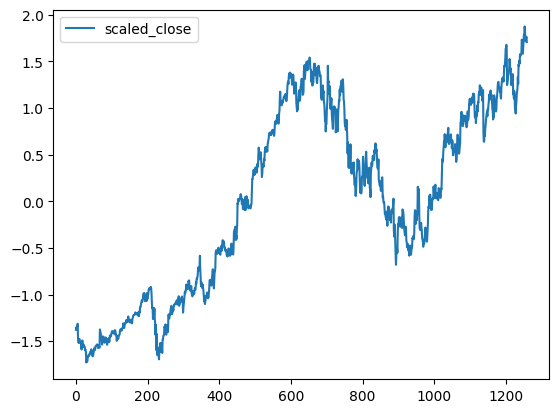

In [45]:
# Visualize scaled data
plt.plot(train_df['Close'], label = 'scaled_close')
plt.legend()
plt.show()

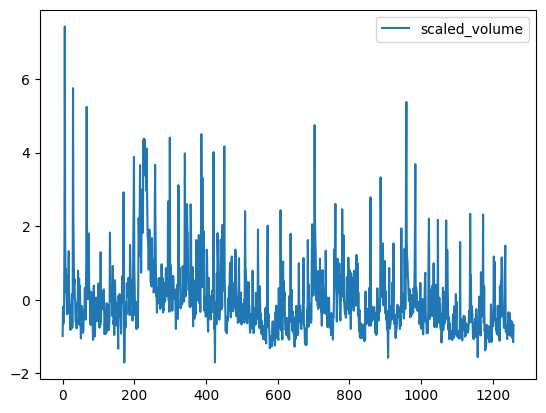

In [46]:
plt.plot(train_df['Volume'], label = 'scaled_volume')
plt.legend()
plt.show()

#### 3. Create sequences
- Create sequences combining `TIME_STEPS` contiguous data values from the training data.
- `TIME_STEP` is set 30 as we want our network to have memory of 30 days.

In [47]:
# def create_sequences(data, time_steps):
#     num_features = data.shape[1]
#     # Create sequences with time steps
#     sequences = []
#     for i in range(len(data) - time_steps + 1):
#         sequence = data[i:i + time_steps]
#         sequences.append(sequence)

#     # Convert sequences to numpy array
#     sequences = np.array(sequences)

#     # Reshape the array to have dimensions (samples, time steps, features)
#     reshaped_data = sequences.reshape(-1, time_steps, num_features)
#     return reshaped_data

# TIME_STEPS = 30

# X_train, y_train = create_sequences(train, TIME_STEPS) , np.array(train[TIME_STEPS:])
# X_test, y_test = create_sequences(test,TIME_STEPS) ,np.array(test[TIME_STEPS:])


# print("Training input shape: ", X_train.shape)
# print("Testing input shape: ", X_test.shape)

In [48]:
def generate_sequences(data, window_size):
  _l = len(data) 
  Xs = []
  Ys = []
  for i in range(0, (_l - window_size)):
    # because this is an autoencoder - our Ys are the same as our Xs. No need to pull the next sequence of values
    Xs.append(data[i:i+window_size])
    Ys.append(data[i:i+window_size])
  return np.array(Xs), np.array(Ys)

In [49]:
TIME_STEPS = 2
X_train, Y_train= generate_sequences(train_df, TIME_STEPS)
print("Training input shape: ", X_train.shape)
print("Training input shape: ", Y_train.shape)

Training input shape:  (1257, 2, 2)
Training input shape:  (1257, 2, 2)


In [50]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

## Build a model

We are building LSTM Autoencoder model. The model will take input of shape `(batch_size, sequence_length, num_features)` and return output of the same shape. In this case, `sequence_length is 30` and `num_features is 2`.

In [51]:
# model = Sequential()
# model.add(LSTM(128, activation = 'tanh', input_shape=( X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(LSTM(64, activation = 'tanh'))
# model.add(Dropout(rate=0.2))
# model.add(RepeatVector(X_train.shape[1]))
# model.add(LSTM(64, activation = 'tanh', return_sequences=True))
# model.add(LSTM(128, activation = 'tanh', return_sequences=True))
# model.add(Dropout(rate=0.2))
# model.add(TimeDistributed(Dense(X_train.shape[2])))
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
# model.summary()

In [52]:
encoder = Sequential()
encoder.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
encoder.add(LSTM(64, activation='relu'))
encoder.add(Dropout(rate=0.1))
encoder.add(RepeatVector(X_train.shape[1]))
# Decoder 
decoder = Sequential() 
decoder.add(LSTM(64, activation='relu', return_sequences=True))
encoder.add(LSTM(128, activation='relu', return_sequences=True))
decoder.add(Dropout(rate=0.1))
decoder.add(TimeDistributed(Dense(X_train.shape[2])))

# Autoencoder
model = Sequential([encoder, decoder])
model.compile(loss='mae', optimizer='adam')

e:\AIO\AnamolyDetection\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



## Train Model

In [53]:
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    #callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.9366 - val_loss: 0.8487
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9193 - val_loss: 0.8359
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7575 - val_loss: 0.6730
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5836 - val_loss: 0.6542
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6922 - val_loss: 0.4930
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4894 - val_loss: 0.6024
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5112 - val_loss: 0.3519
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3627 - val_loss: 0.3359
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4066 - val_loss: 0.4386
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3198 - val_loss: 0.3398
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3469 - val_loss: 0.3813
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0

#### Plot Training - Validation loss

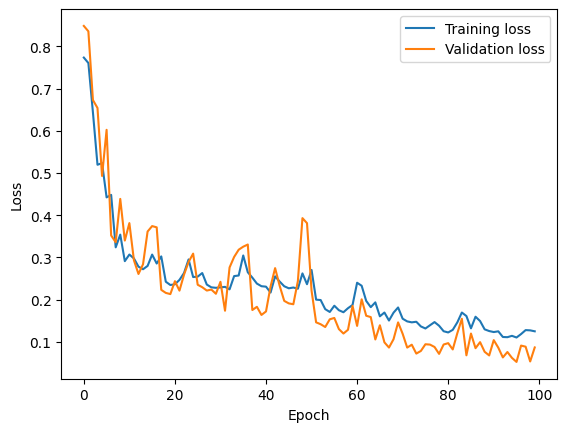

In [54]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step
Reconstruction error threshold for close: 0.5519891503194903
Reconstruction error threshold for volume: 0.7262457862397363


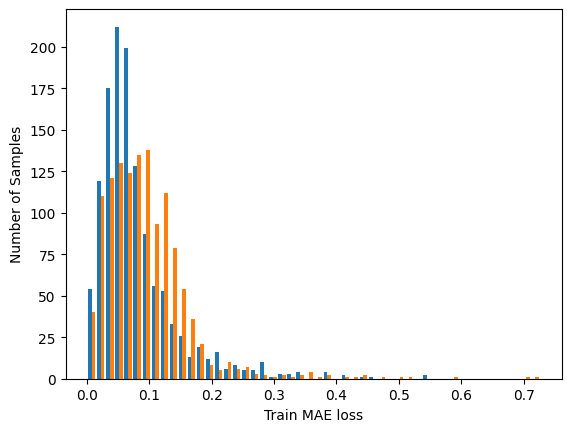

In [55]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

max_values = np.max(train_mae_loss, axis=0)
close_threshold = max_values[0]
volume_threshold = max_values[1]


print('Reconstruction error threshold for close:',close_threshold)
print('Reconstruction error threshold for volume:',volume_threshold)

## Predict Anomalies on test data using threshold

In [56]:
new_df = pd.read_csv('Stocks\TestAnomaly.csv')
new_df = new_df[['Date','Close','Volume']]
scaled_new_test = scaler.transform(new_df[['Close','Volume']])

X_new, Y_new = generate_sequences(scaled_new_test, TIME_STEPS)
new_test_pred = model.predict(X_new, verbose=1)
new_mae_loss = np.mean(np.abs(new_test_pred-X_new), axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [57]:
anomaly_df = new_df[TIME_STEPS:]
print(anomaly_df.head())
print(len(anomaly_df))

        Date       Close      Volume
2  4/22/2024  151.149994  15114700.0
3  4/23/2024  151.699997  19312700.0
4  4/24/2024  151.940002  16622000.0
5  4/25/2024  152.259995  21105600.0
6  4/26/2024  156.500000  24469800.0
148


In [58]:
test_mae_loss_df = pd.DataFrame(new_mae_loss, columns=['Close_Loss','Volume_Loss'])

anomaly_df['Close_Loss'] = np.array(test_mae_loss_df['Close_Loss'])
anomaly_df['Volume_Loss'] = np.array(test_mae_loss_df['Volume_Loss'])
anomaly_df.head()

C:\Users\ragam\AppData\Local\Temp\ipykernel_13124\4242969946.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ragam\AppData\Local\Temp\ipykernel_13124\4242969946.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Close,Volume,Close_Loss,Volume_Loss
2,4/22/2024,151.149994,15114700.0,0.133974,0.102876
3,4/23/2024,151.699997,19312700.0,0.162473,0.103238
4,4/24/2024,151.940002,16622000.0,0.133735,0.141120
5,4/25/2024,152.259995,21105600.0,0.155229,0.105637
6,4/26/2024,156.500000,24469800.0,0.129578,0.149926


In [59]:
print(test_mae_loss_df['Close_Loss'].max())
print(test_mae_loss_df['Volume_Loss'].max())

12.545225704566716
6.575979650020599


In [60]:
anomaly_df['anomaly'] = np.where((anomaly_df['Close_Loss'] > close_threshold) & (anomaly_df['Volume_Loss'] > volume_threshold), True, False)
anomaly_df.head()

C:\Users\ragam\AppData\Local\Temp\ipykernel_13124\1775953158.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Close,Volume,Close_Loss,Volume_Loss,anomaly
2,4/22/2024,151.149994,15114700.0,0.133974,0.102876,False
3,4/23/2024,151.699997,19312700.0,0.162473,0.103238,False
4,4/24/2024,151.940002,16622000.0,0.133735,0.141120,False
5,4/25/2024,152.259995,21105600.0,0.155229,0.105637,False
6,4/26/2024,156.500000,24469800.0,0.129578,0.149926,False


In [61]:
anomaly_df['anomaly'].value_counts()

anomaly
False    125
True      23
Name: count, dtype: int64

In [62]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['Close_Loss'], name='Close loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['Volume_Loss'], name='Volume loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=np.array([close_threshold]*len(anomaly_df)), name='Close Threshold'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=np.array([volume_threshold]*len(anomaly_df)), name='Volume Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [63]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Date,Close,Volume,Close_Loss,Volume_Loss,anomaly
16,5/6/2024,400.404999,88888880.00,2.599374,1.305672,True
17,5/7/2024,300.555000,88888880.00,6.392381,1.643361,True
18,5/8/2024,156.880005,16237800.00,4.971809,2.429835,True
42,6/1/2024,350.320719,11577957.14,2.364936,1.017715,True
43,6/2/2024,157.351433,11332514.29,6.584957,1.321561,True


In [64]:
source_data = scaler.inverse_transform(anomaly_df[['Close', 'Volume']])

anomaly_data = scaler.inverse_transform(anomalies[['Close','Volume']])


In [65]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=source_data[:,0], name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=anomaly_data[:,0], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

In [66]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=source_data[:,1], name='Volume'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=anomaly_data[:,1], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()